In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [207]:
#https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent?select=houses_to_rent_v2.csv
dataset = pd.read_csv("data/houses_to_rent_v2.csv")

In [86]:
dataset.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [208]:
#будет рассматриваться только rent amount (R$)
dataset.drop(['property tax (R$)', 'fire insurance (R$)', 'total (R$)'], axis = 1, inplace=True)

In [209]:
dataset.isnull().sum()

city                0
area                0
rooms               0
bathroom            0
parking spaces      0
floor               0
animal              0
furniture           0
hoa (R$)            0
rent amount (R$)    0
dtype: int64

In [187]:
dataset.dtypes

city                object
area                 int64
rooms                int64
bathroom             int64
parking spaces       int64
floor               object
animal              object
furniture           object
hoa (R$)             int64
rent amount (R$)     int64
dtype: object

In [188]:
dataset['floor'].unique()

array(['7', '20', '6', '2', '1', '-', '4', '3', '10', '11', '24', '9',
       '8', '17', '18', '5', '13', '15', '16', '14', '26', '12', '21',
       '19', '22', '27', '23', '35', '25', '46', '28', '29', '301', '51',
       '32'], dtype=object)

In [210]:
dataset.loc[dataset['floor']=='-', 'floor'] = 1
dataset['floor'] = dataset['floor'].astype(str).astype(int)

In [211]:
dataset.rename(columns={"hoa (R$)": "hoa tax", "rent amount (R$)": "rent amount"}, inplace=True)

Text(0.5, 1.0, 'Распределение цены')

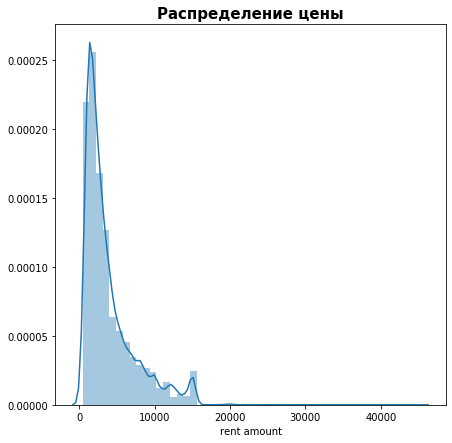

In [191]:
plt.figure(figsize=(7,7))
sns.distplot(dataset['rent amount'])
plt.title("Распределение цены",size=15, weight='bold')

In [212]:
'''''
Иногда при построении регрессии целесообразно преобразовать зависимую переменную у. 
Прогнозирование частот является довольно распространенной задачей, 
и преобразование log(у + 1) часто помогает.
'''''
dataset['rent_log'] = np.log(dataset['rent amount']+1)
dataset.drop(['rent amount'], axis = 1, inplace=True)

Text(0.5, 1.0, 'Логарифмическое распределение цены')

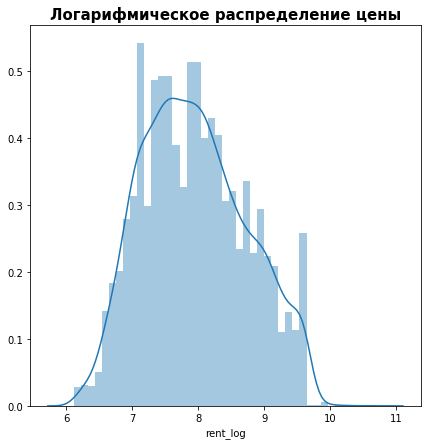

In [18]:
plt.figure(figsize=(7,7))
sns.distplot(dataset['rent_log'])
plt.title("Логарифмическое распределение цены", size=15, weight='bold')

In [193]:
dataset_dummies = pd.get_dummies(dataset.drop(['rent_log'], axis = 1))

In [213]:
dataset.loc[dataset['furniture']=='furnished', 'furniture'] = 1
dataset.loc[dataset['furniture']=='not furnished', 'furniture'] = 0

dataset.loc[dataset['animal']=='acept', 'animal'] = 1
dataset.loc[dataset['animal']=='not acept', 'animal'] = 0

In [195]:
#Series.cat.codes: return Series of codes as well as the index.
def change_with_cat_codes(df, list_of_columns):
    for column in list_of_columns:
        df[column] = df[column].astype('category').cat.codes
    return df

In [214]:
change_with_cat_codes(dataset, ['city', 'furniture', 'animal'])

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa tax,rent_log
0,4,70,2,1,1,7,1,1,2065,8.101981
1,4,320,4,4,0,20,1,0,1200,8.509363
2,2,80,1,1,1,6,1,0,1000,7.937732
3,2,51,2,1,0,2,1,0,270,7.014814
4,4,25,1,1,0,1,0,0,0,6.685861
...,...,...,...,...,...,...,...,...,...,...
10687,2,63,2,1,1,5,0,1,402,7.299121
10688,4,285,4,4,4,17,1,0,3100,9.615872
10689,3,70,3,3,0,8,0,1,980,8.699681
10690,3,120,2,2,2,8,1,1,1585,9.392745


Text(0.5, 1, 'Корреляция между признаками')

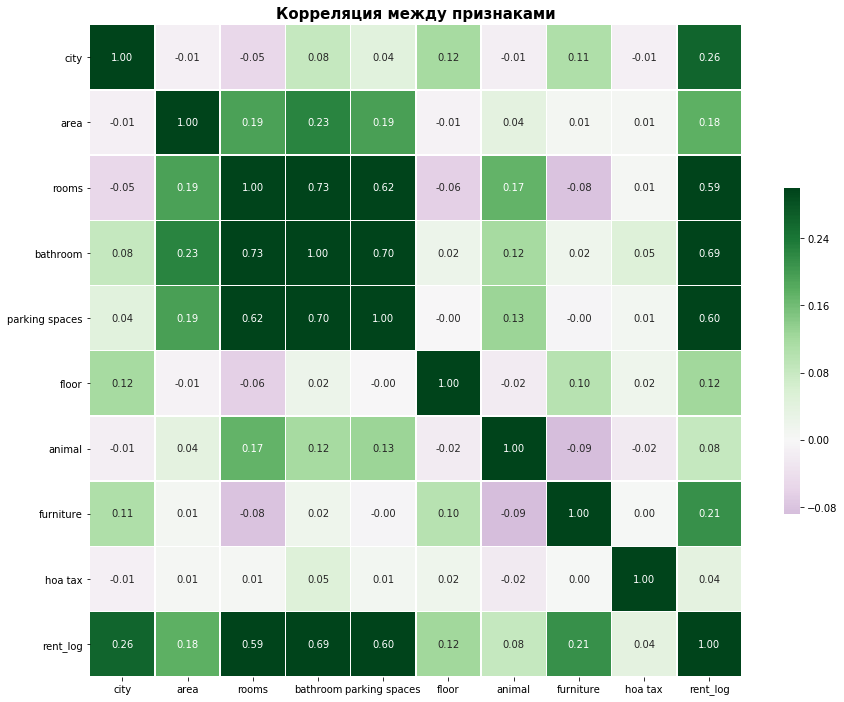

In [197]:
'''
Для более стабильной регрессии следуюет убирать признаки, которые имеют
высокую корреляцию с зависимой переменной у, так как при высокой корреляции
увеличивается дисперсия вектора весов.
https://towardsdatascience.com/why-exclude-highly-correlated-features-when-building-regression-model-34d77a90ea8e
'''
plt.figure(figsize=(15,12))
corr = dataset.corr(method='pearson') 
sns.heatmap(corr, annot=True, fmt='.2f', cmap='PRGn', vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(10, 0))
plt.title("Корреляция между признаками", size=15, weight='bold')

In [198]:
'''
Мультиколлинеарность — наличие линейной зависимости между объясняющими переменными (факторами) регрессионной модели.
Один из способов нахождения мультиколлинеарности - нахождение собственных значений (eigenvalues) корреляционной матрицы.
Малые и нулевые значения собственных значений свидетельствует о наличии мультиколлинеарности.
'''
eigenvalues, eigenvectors = np.linalg.eig(corr)
eigenvalues

array([3.09524374, 1.36092456, 0.22869806, 0.2830876 , 0.38379388,
       1.01785232, 0.97645131, 0.8620302 , 0.87135753, 0.92056082])

In [225]:
'''
Из трёх признаков rooms, bathroom, parking spaces остаётся только один,
так как они сильно коррелируют между собой
'''
droped = dataset.drop(['bathroom', 'parking spaces'], axis = 1)

Text(0.5, 1, 'Корреляция между признаками')

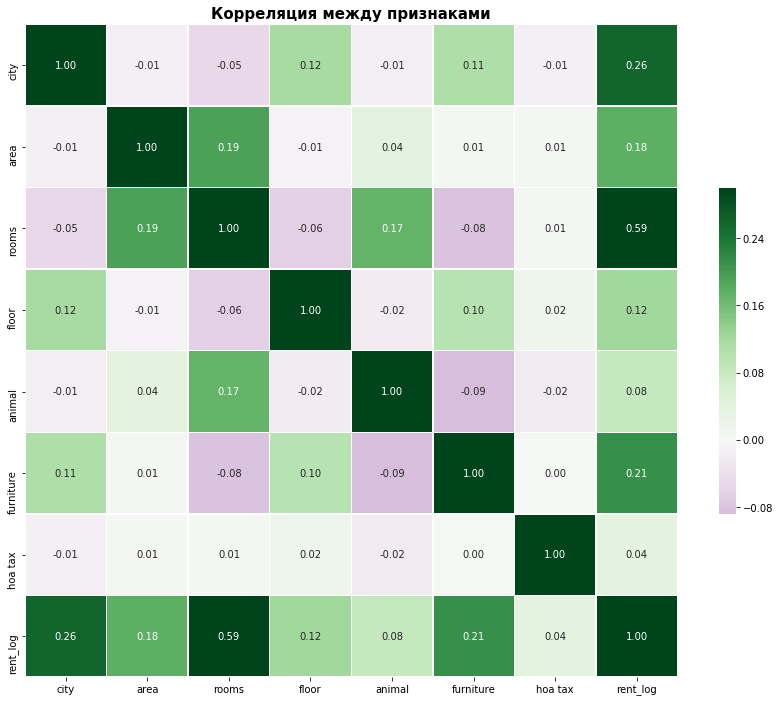

In [223]:
plt.figure(figsize=(15,12))
corr = droped.corr(method='pearson') 
sns.heatmap(corr, annot=True, fmt='.2f', cmap='PRGn', vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(8, 0))
plt.title("Корреляция между признаками", size=15, weight='bold')

In [215]:
x, y = dataset.iloc[:,:-1], dataset.iloc[:,-1]

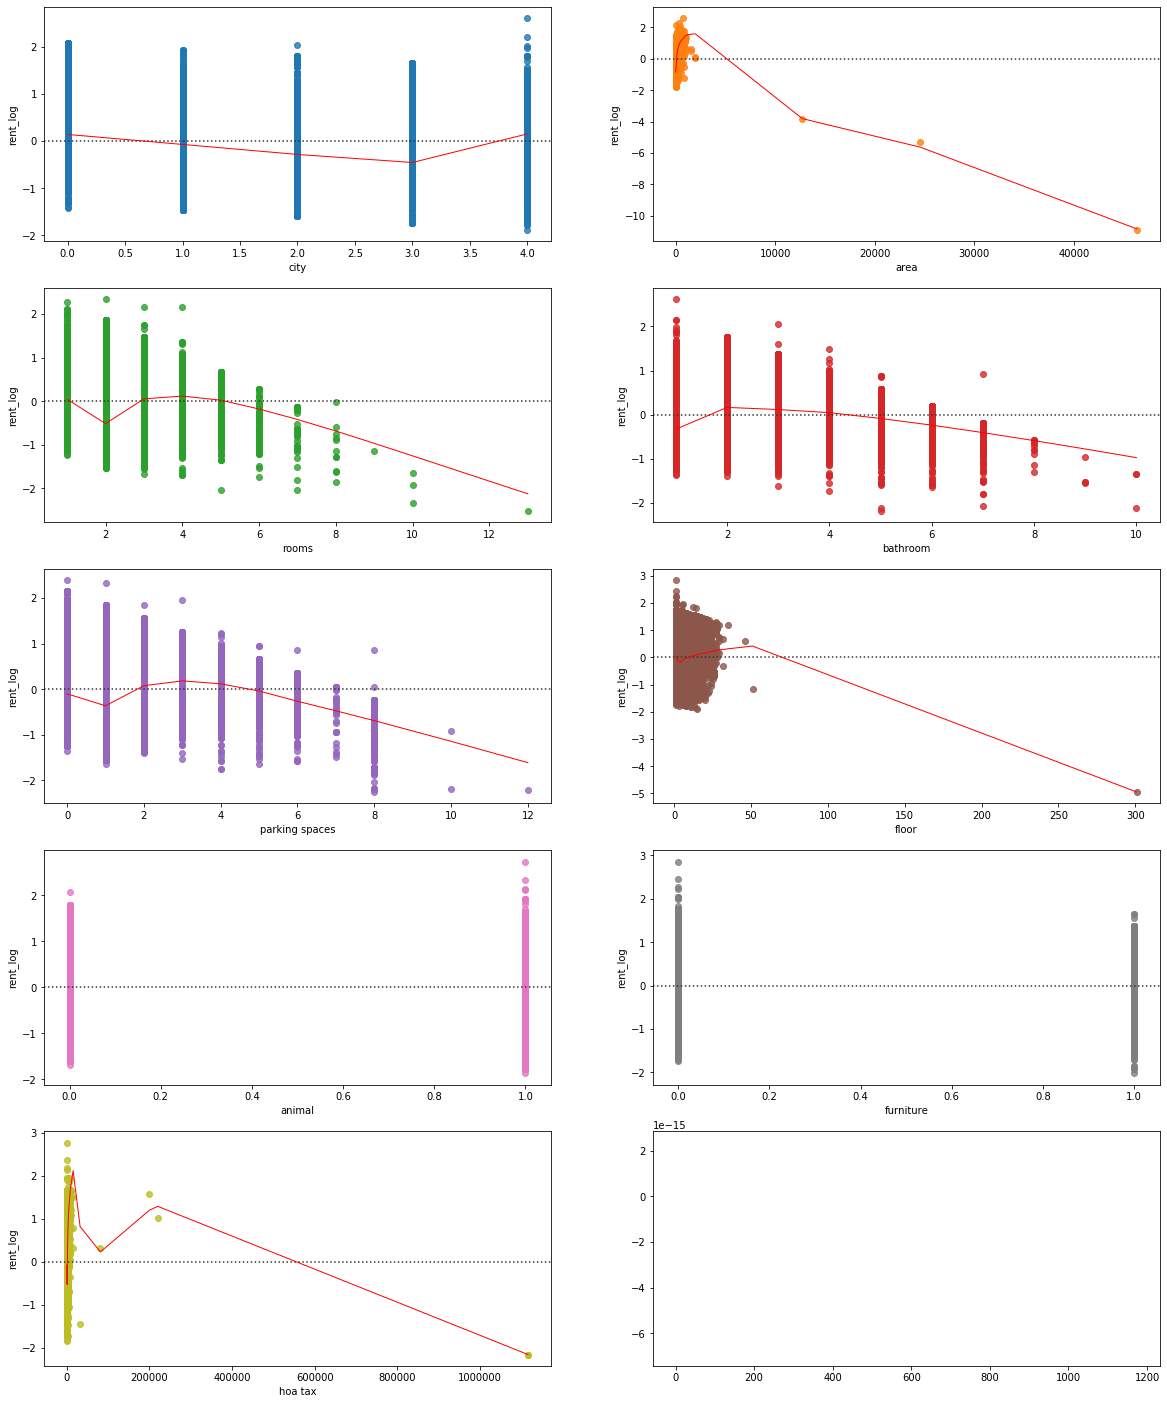

In [224]:
'''
Residual - это разница между тем, что отображается на диаграмме рассеяния в определенной точке,
и тем, что, согласно уравнению регрессии, «должно быть нанесено» в этой конкретной точке. 
Residual plot - это график, который показывает остатки по вертикальной оси и независимую переменную по горизонтальной оси.
Если точки случайным образом рассредоточены вокруг горизонтальной оси, для данных подходит модель линейной регрессии;
в противном случае более подходящей является нелинейная модель.
'''
f, axes = plt.subplots(5, 2, figsize=(20, 25))
sns.residplot(x.iloc[:,0], y, lowess=True, ax=axes[0, 0], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,1], y, lowess=True, ax=axes[0, 1], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,2], y, lowess=True, ax=axes[1, 0], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,3], y, lowess=True, ax=axes[1, 1], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,4], y, lowess=True, ax=axes[2, 0], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,5], y, lowess=True, ax=axes[2, 1], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,6], y, lowess=True, ax=axes[3, 0], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,7], y, lowess=True, ax=axes[3, 1], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,8], y, lowess=True, ax=axes[4, 0], line_kws={'color': 'red', 'lw': 1})

In [136]:
'''
Применение StandardScaler гарантирует, что для каждого признака среднее будет равно 0,
а дисперсия будет равна 1, в результате чего все признаки будут иметь один и тот же масштаб.
'''
def scale_and_split(x, y):
    scaler = StandardScaler().fit(x)
    dataset_scaled = scaler.transform(x)
    X_train, X_test, y_train, y_test = train_test_split(dataset_scaled, y, random_state=5)
    return X_train, X_test, y_train, y_test, dataset_scaled

In [227]:
X_train, X_test, y_train, y_test, dataset_scaled = scale_and_split(x, y)
x_d = droped.iloc[:,:-1]
X_train_d, X_test_d, y_train_d, y_test_d, dataset_scaled_d = scale_and_split(x_d, y)

In [138]:
#Нахождение оптимальных параметров для каждого вида регресии.
param_grid = {'alpha': [1,0.1,0.01,0.001,0.0001,10,100]}
grid_search = GridSearchCV(Ridge(), param_grid).fit(X_train, y_train)
print("Лучшие параметры: {}".format(grid_search.best_params_))
print("Лучший результат: {}".format(grid_search.best_score_))

Лучшие параметры: {'alpha': 100}
Лучший результат: 0.5833855130000665


In [139]:
grid_search = GridSearchCV(Lasso(), param_grid).fit(X_train, y_train)
print("Лучшие параметры: {}".format(grid_search.best_params_))
print("Лучший результат: {}".format(grid_search.best_score_))

Лучшие параметры: {'alpha': 0.01}
Лучший результат: 0.6068178692493488


In [140]:
grid_search = GridSearchCV(ElasticNet(), param_grid).fit(X_train, y_train)
print("Лучшие параметры: {}".format(grid_search.best_params_))
print("Лучший результат: {}".format(grid_search.best_score_))

Лучшие параметры: {'alpha': 0.01}
Лучший результат: 0.597063624430051


In [242]:
def show_results(estimator, X_train, X_test, y_train, y_test, dataset_scaled, y):
    estimatorScores = cross_val_score(estimator, dataset_scaled, y)
    print("\nРезультат перекрестной проверки: {}".format(estimatorScores))
    print("Средняя правильность перекрестной проверки: {:.3f}".format(estimatorScores.mean()))

    estimator.fit(X_train, y_train)
    estimator_pred = estimator.predict(X_test)
    print('\nMAE: {:.4f}'.format(mean_absolute_error(y_test, estimator_pred)))
    print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, estimator_pred))))   
    print('R2 {:.4f}'.format(r2_score(y_test, estimator_pred)))

In [248]:
print("LinearRegression")
show_results(LinearRegression(), X_train, X_test, y_train, y_test, dataset_scaled, y)

print("\nLinearRegression без двух столбцов")
show_results(LinearRegression(), X_train_d, X_test_d, y_train_d, y_test_d, dataset_scaled_d, y)

LinearRegression

Результат перекрестной проверки: [0.60905104 0.60981651 0.60896889]
Средняя правильность перекрестной проверки: 0.609

MAE: 0.3795
RMSE: 0.4844
R2 0.6294

LinearRegression без двух столбцов

Результат перекрестной проверки: [0.49148128 0.49707649 0.49816726]
Средняя правильность перекрестной проверки: 0.496

MAE: 0.4329
RMSE: 0.5431
R2 0.5341


In [244]:
print('Ridge, L2')
show_results(Ridge(alpha=100), X_train, X_test, y_train, y_test, dataset_scaled, y)

Ridge, L2

Результат перекрестной проверки: [0.60922504 0.60963119 0.60909913]
Средняя правильность перекрестной проверки: 0.609

MAE: 0.3798
RMSE: 0.4844
R2 0.6293


In [245]:
print('Lasso, L1')
show_results(Lasso(alpha=0.01), X_train, X_test, y_train, y_test, dataset_scaled, y)

Lasso, L1

Результат перекрестной проверки: [0.61408659 0.60721964 0.60855452]
Средняя правильность перекрестной проверки: 0.610

MAE: 0.3816
RMSE: 0.4854
R2 0.6279


In [246]:
print('ElasticNet, L1+L2')
show_results(ElasticNet(alpha=0.01), X_train, X_test, y_train, y_test, dataset_scaled, y)

ElasticNet, L1+L2

Результат перекрестной проверки: [0.61218827 0.60868619 0.60898591]
Средняя правильность перекрестной проверки: 0.610

MAE: 0.3806
RMSE: 0.4847
R2 0.6289
